In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
import env

Use basic probability to identify anomalous requests. Using the methods covered in this lesson, examine the rest of the features in the api access logs data set.

In [2]:
# acquire the data
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
# df = pd.concat([df.entry, df.entry.apply(parse_log_entry)], axis=1)
df = df.entry.apply(parse_log_entry)
df.head()


,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [3]:
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)


In [4]:
# convert the date to datetime and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13978 entries, 2019-04-16 19:34:42 to 2019-04-19 19:42:41
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13978 non-null  object
 1   request_method  13978 non-null  object
 2   request_path    13978 non-null  object
 3   http_version    13978 non-null  object
 4   status_code     13978 non-null  object
 5   size            13978 non-null  int64 
 6   user_agent      13978 non-null  object
dtypes: int64(1), object(6)
memory usage: 873.6+ KB


In [6]:
# create a new column that converts sixe into MB
df['size_mb'] = df['size'] / 1024 / 1024

In [7]:
df.describe()

,size,size_mb
count,1.397800e+04,13978.000000
mean,4.500019e+05,0.429155
std,1.614915e+05,0.154010
min,0.000000e+00,0.000000
25%,5.006370e+05,0.477445
50%,5.101380e+05,0.486506
75%,5.112910e+05,0.487605
max,2.056327e+06,1.961066


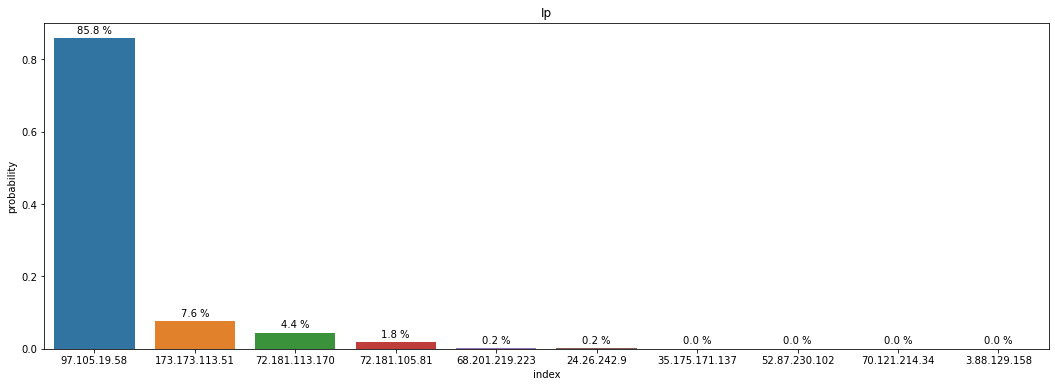

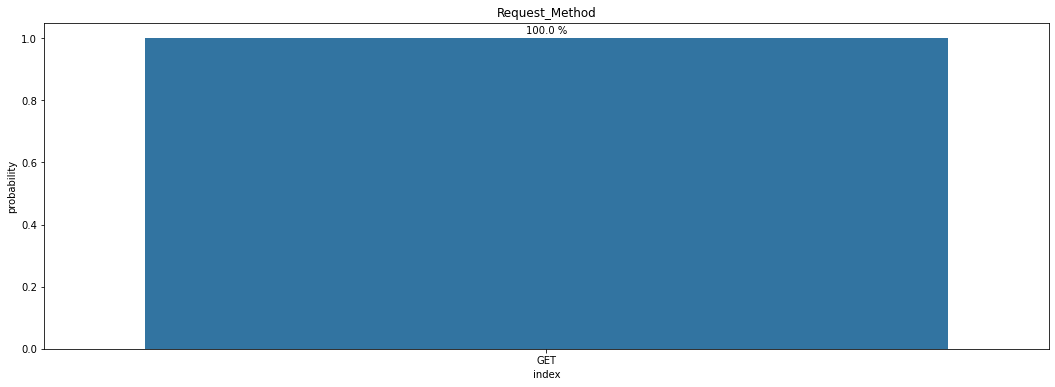

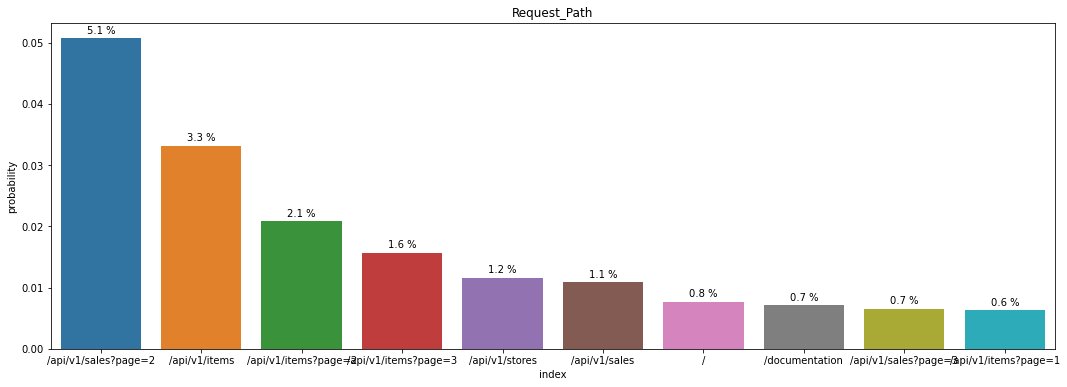

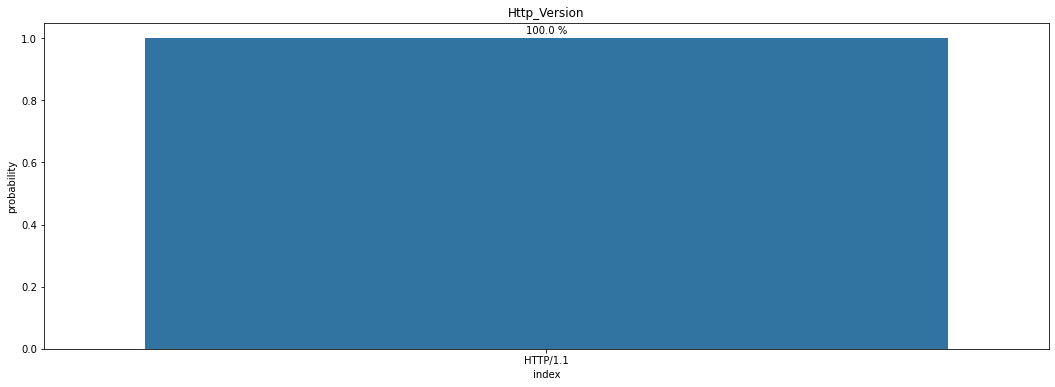

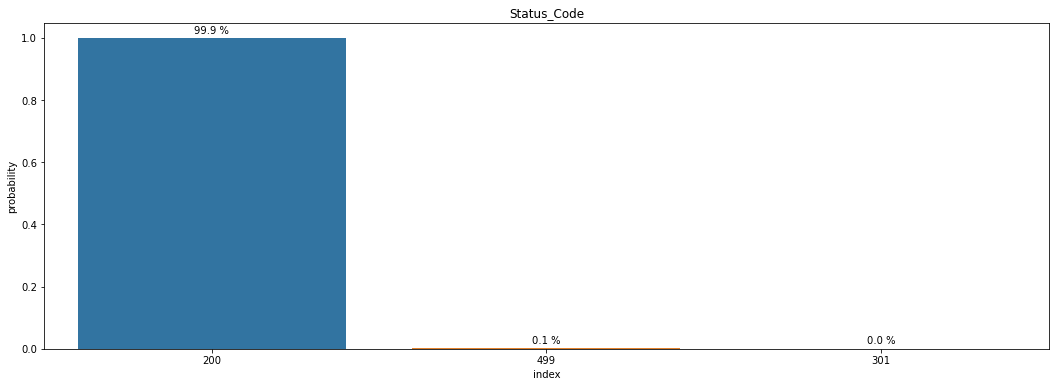

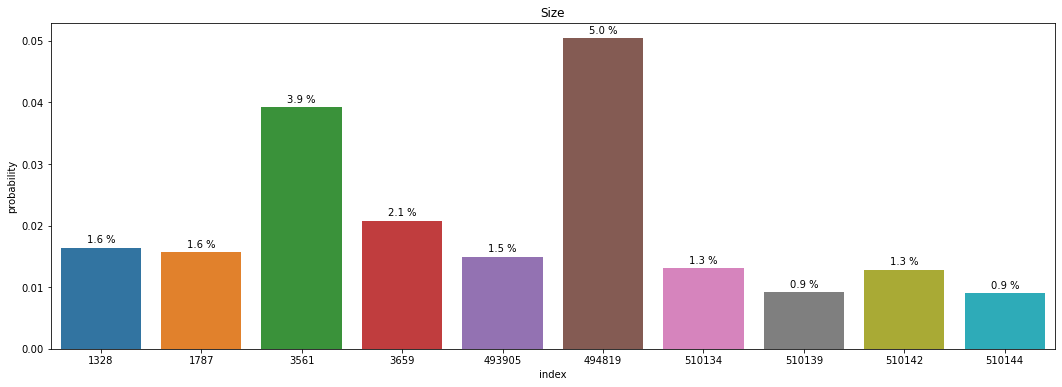

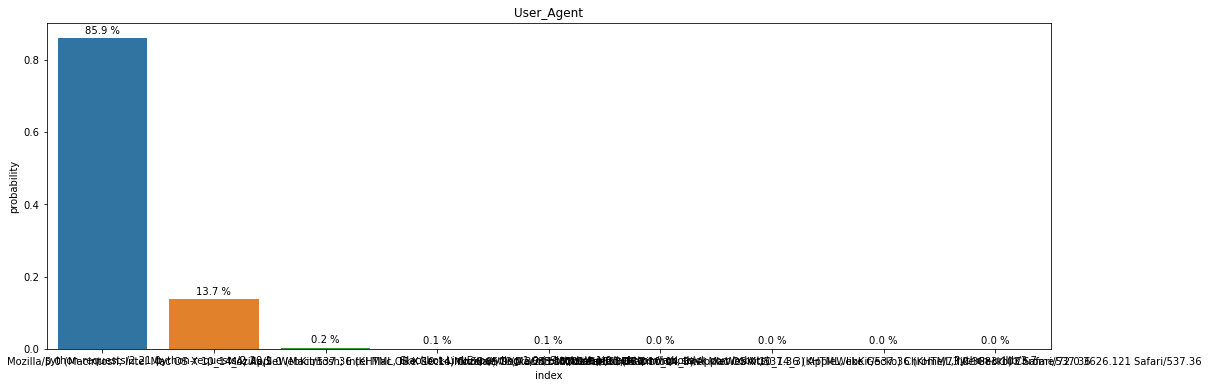

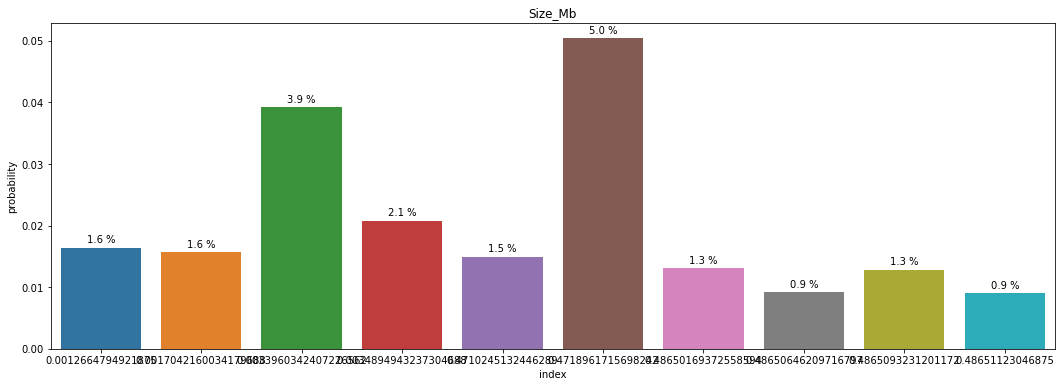

In [8]:
# create a visualization of the data
for col in df.columns:
    plt.figure(figsize=(18, 6))
    splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
        by=col, ascending=False).head(10))
    for p in splot.patches:
        splot.annotate(format(p.get_height() * 100, '.1f') + ' %', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=10,
                   xytext = (0, 8), 
                   textcoords = 'offset points')
    plt.title(col.title())
    plt.ylabel('probability')
    plt.show()

In [9]:
# value counts of unique ip addresses
df_ip = pd.DataFrame(df.ip.value_counts(dropna=False)).reset_index().\
                rename(columns={'index': 'ip', 'ip': 'ip_count'})

In [10]:
# determine the probability of an ip address
df_ipp = pd.DataFrame(df.ip.value_counts(dropna = False)/df.ip.count()).reset_index().rename(index = str , columns = {'index':'ip','ip':'ip_proba'})

In [11]:
# combine the two dataframes
ip_df = df_ip.merge(df_ipp)

In [12]:
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ip        22 non-null     object 
 1   ip_count  22 non-null     int64  
 2   ip_proba  22 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 704.0+ bytes
